<a href="https://colab.research.google.com/github/LucaChuang/Beijing-Multi-Site-Air-Quality-Prediction/blob/main/Project3_Team1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Gathering

## Merge two weather datasets

The ASOS network data is collected in Beijing Capital International Airport(ZBAA) which located at Shunyi district, so we enrich this dataset with Beijing Municipal Environmental Monitoring Center data for Shunyi district. 

### ASOS Network data

In [ ]:
# read in the asos data
asos = pd.read_csv("/content/drive/Shared drives/Deep Learning Team1/Project 3/Data/asos.txt", sep=",")
asos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69959 entries, 0 to 69958
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station            69959 non-null  object 
 1   valid              69959 non-null  object 
 2   tmpf               69959 non-null  float64
 3   dwpf               69959 non-null  float64
 4   relh               69959 non-null  float64
 5   drct               55539 non-null  float64
 6   sknt               69959 non-null  float64
 7   p01i               69959 non-null  float64
 8   alti               69959 non-null  float64
 9   mslp               0 non-null      float64
 10  vsby               69959 non-null  float64
 11  gust               2268 non-null   float64
 12  skyc1              30100 non-null  object 
 13  skyc2              1718 non-null   object 
 14  skyc3              72 non-null     object 
 15  skyc4              0 non-null      float64
 16  skyl1              569

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# remove 
asos = asos[['station','valid','relh','p01i','vsby']]
asos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69959 entries, 0 to 69958
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   station  69959 non-null  object 
 1   valid    69959 non-null  object 
 2   relh     69959 non-null  float64
 3   p01i     69959 non-null  float64
 4   vsby     69959 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.7+ MB


In [ ]:
asos.head()

,station,valid,relh,p01i,vsby
0,ZBAA,2013-03-01 00:00,20.01,0.0,6.21
1,ZBAA,2013-03-01 00:30,18.60,0.0,6.21
2,ZBAA,2013-03-01 01:00,13.24,0.0,6.21
3,ZBAA,2013-03-01 01:30,12.10,0.0,6.21
4,ZBAA,2013-03-01 02:00,13.24,0.0,6.21


In [ ]:
asos['station'].value_counts()

ZBAA    69959
Name: station, dtype: int64

In [ ]:
asos['valid'] = pd.to_datetime(asos['valid'])
asos

,station,valid,relh,p01i,vsby
0,ZBAA,2013-03-01 00:00:00,20.01,0.0,6.21
1,ZBAA,2013-03-01 00:30:00,18.60,0.0,6.21
2,ZBAA,2013-03-01 01:00:00,13.24,0.0,6.21
3,ZBAA,2013-03-01 01:30:00,12.10,0.0,6.21
4,ZBAA,2013-03-01 02:00:00,13.24,0.0,6.21
...,...,...,...,...,...
69954,ZBAA,2017-02-27 21:30:00,44.25,0.0,6.21
69955,ZBAA,2017-02-27 22:00:00,40.93,0.0,6.21
69956,ZBAA,2017-02-27 22:30:00,44.25,0.0,6.21
69957,ZBAA,2017-02-27 23:00:00,28.64,0.0,6.21


### Beijing Municipal Environmental Monitoring Center data


In [ ]:
shunyi = pd.read_csv("/content/drive/Shared drives/Deep Learning Team1/Project 3/Data/PRSA_Data_Shunyi_20130301-20170228.csv")
shunyi.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,3.0,6.0,3.0,8.0,300.0,44.0,-0.9,1025.8,-20.5,0.0,NW,9.3,Shunyi
1,2,2013,3,1,1,12.0,12.0,3.0,7.0,300.0,47.0,-1.1,1026.1,-21.3,0.0,NW,9.4,Shunyi
2,3,2013,3,1,2,14.0,14.0,NaN,7.0,200.0,22.0,-1.7,1026.2,-23.0,0.0,NW,8.6,Shunyi
3,4,2013,3,1,3,12.0,12.0,3.0,5.0,NaN,NaN,-2.1,1027.3,-23.3,0.0,NW,6.6,Shunyi
4,5,2013,3,1,4,12.0,12.0,3.0,NaN,200.0,11.0,-2.4,1027.7,-22.9,0.0,NW,4.5,Shunyi


In [ ]:
shunyi['valid'] = shunyi["year"].astype(str) + "-" + shunyi["month"].astype(str) + \
                      "-" + shunyi["day"].astype(str) + " " + shunyi["hour"].astype(str)+\
                      ":" + "00"

In [ ]:
shunyi["valid"]= pd.to_datetime(shunyi["valid"])

In [ ]:
shunyi = shunyi.drop(columns="No")

In [ ]:
# check the shape of two datasets
print(asos.shape)
print(shunyi.shape)

(69959, 5)
(35064, 18)


In [ ]:
# merge asos dataset and shunyi dataset 
df = shunyi.merge(asos, how='left',left_on='valid',right_on='valid' )
print(df.shape)

(35069, 22)


In [ ]:
# There are extra 5 rows because of duplicate issue, we will fix it! Don't  worry!
# webdata.drop_duplicates(), maybe like this
asos['valid'].astype(str)
asos['valid'].value_counts()

2014-04-26 07:00:00    3
2014-04-26 10:00:00    2
2014-04-26 07:30:00    2
2014-04-26 10:30:00    2
2014-04-26 08:00:00    2
                      ..
2015-08-07 21:30:00    1
2013-04-25 21:30:00    1
2016-11-23 12:00:00    1
2014-08-12 12:00:00    1
2013-06-07 22:00:00    1
Name: valid, Length: 69952, dtype: int64

In [ ]:
# drop duplicate timestamp in asos dataset
asos = asos.drop_duplicates(subset=['valid'], keep='first')

In [ ]:
# merge shunyi data and asos data again
df = shunyi.merge(asos, how='left',left_on='valid',right_on='valid' )
print(df.shape) # (35064,28)
df.head()

(35064, 22)


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station_x,valid,station_y,relh,p01i,vsby
0,2013,3,1,0,3.0,6.0,3.0,8.0,300.0,44.0,-0.9,1025.8,-20.5,0.0,NW,9.3,Shunyi,2013-03-01 00:00:00,ZBAA,20.01,0.0,6.21
1,2013,3,1,1,12.0,12.0,3.0,7.0,300.0,47.0,-1.1,1026.1,-21.3,0.0,NW,9.4,Shunyi,2013-03-01 01:00:00,ZBAA,13.24,0.0,6.21
2,2013,3,1,2,14.0,14.0,NaN,7.0,200.0,22.0,-1.7,1026.2,-23.0,0.0,NW,8.6,Shunyi,2013-03-01 02:00:00,ZBAA,13.24,0.0,6.21
3,2013,3,1,3,12.0,12.0,3.0,5.0,NaN,NaN,-2.1,1027.3,-23.3,0.0,NW,6.6,Shunyi,2013-03-01 03:00:00,ZBAA,11.47,0.0,6.21
4,2013,3,1,4,12.0,12.0,3.0,NaN,200.0,11.0,-2.4,1027.7,-22.9,0.0,NW,4.5,Shunyi,2013-03-01 04:00:00,ZBAA,11.68,0.0,6.21


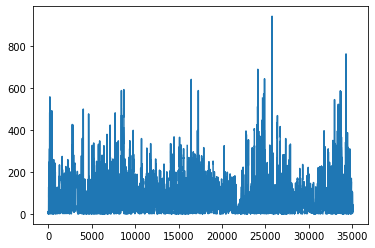

In [ ]:
# visualize the data
df['PM2.5'].plot()
plt.show()

In [ ]:
# drop those columns don't need for model
df.drop(columns=['wd','station_x','station_y','year','month','day','hour','valid'],inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   34151 non-null  float64
 1   PM10    34516 non-null  float64
 2   SO2     33768 non-null  float64
 3   NO2     33699 non-null  float64
 4   CO      32886 non-null  float64
 5   O3      33575 non-null  float64
 6   TEMP    35013 non-null  float64
 7   PRES    35013 non-null  float64
 8   DEWP    35010 non-null  float64
 9   RAIN    35013 non-null  float64
 10  WSPM    35020 non-null  float64
 11  relh    34984 non-null  float64
 12  p01i    34984 non-null  float64
 13  vsby    34984 non-null  float64
dtypes: float64(14)
memory usage: 4.0 MB


In [ ]:
# fill in missing value with previous value
df=df.fillna(method='ffill')
Y=df['PM2.5']
X = df.drop(axis=1, columns=['PM2.5'])
# put Y all the way on the left
df = pd.concat([X, Y], axis=1, sort=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM10    35064 non-null  float64
 1   SO2     35064 non-null  float64
 2   NO2     35064 non-null  float64
 3   CO      35064 non-null  float64
 4   O3      35064 non-null  float64
 5   TEMP    35064 non-null  float64
 6   PRES    35064 non-null  float64
 7   DEWP    35064 non-null  float64
 8   RAIN    35064 non-null  float64
 9   WSPM    35064 non-null  float64
 10  relh    35064 non-null  float64
 11  p01i    35064 non-null  float64
 12  vsby    35064 non-null  float64
 13  PM2.5   35064 non-null  float64
dtypes: float64(14)
memory usage: 4.0 MB


# Modeling

## Baseline Model

In [ ]:
# baseline model - prediction is just the previous time step (a tough one to beat!)
df_for_baseline = pd.DataFrame(df['PM2.5'])
df_for_baseline['Baseline'] = df_for_baseline['PM2.5'].shift(24)
df_for_baseline = df_for_baseline.iloc[24:,:]
df_for_baseline.head()

,PM2.5,Baseline
24,5.0,3.0
25,3.0,12.0
26,4.0,14.0
27,8.0,12.0
28,6.0,12.0


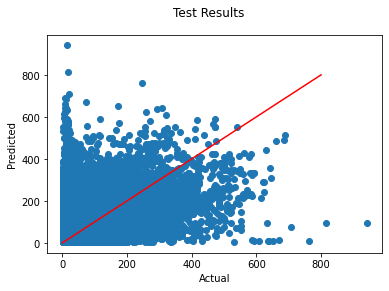

In [ ]:
# now set this equal to pred and repeat code!

# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = df_for_baseline['Baseline'] # the pred
actual = df_for_baseline['PM2.5'] # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,800) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks not good!

In [ ]:
from sklearn import metrics
print("Baseline MAE:", metrics.mean_absolute_error(actual,pred))
print("Baseline MSE:",metrics.mean_squared_error(actual,pred))

Baseline MAE: 59.76905251141553
Baseline MSE: 8159.308686643835


## Sequence

In [ ]:
# shift our target forward one hour.
# we want to use today's 24 hour data to predict the next 24 hour PM2.5 data.
df['PM2.5-1']=df['PM2.5'].shift(-1,fill_value=0)
df.drop(columns=['PM2.5'],inplace=True)
df

,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,relh,p01i,vsby,PM2.5-1
0,6.0,3.0,8.0,300.0,44.0,-0.9,1025.8,-20.5,0.0,9.3,20.01,0.0,6.21,12.0
1,12.0,3.0,7.0,300.0,47.0,-1.1,1026.1,-21.3,0.0,9.4,13.24,0.0,6.21,14.0
2,14.0,3.0,7.0,200.0,22.0,-1.7,1026.2,-23.0,0.0,8.6,13.24,0.0,6.21,12.0
3,12.0,3.0,5.0,200.0,22.0,-2.1,1027.3,-23.3,0.0,6.6,11.47,0.0,6.21,12.0
4,12.0,3.0,5.0,200.0,11.0,-2.4,1027.7,-22.9,0.0,4.5,11.68,0.0,6.21,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,72.0,8.0,92.0,800.0,16.0,10.3,1014.2,-12.4,0.0,1.8,28.64,0.0,6.21,47.0
35060,55.0,17.0,86.0,1100.0,19.0,9.8,1014.5,-9.9,0.0,1.5,28.64,0.0,6.21,18.0
35061,28.0,4.0,30.0,500.0,64.0,9.1,1014.6,-12.7,0.0,1.7,28.64,0.0,6.21,18.0
35062,20.0,9.0,33.0,500.0,59.0,7.1,1015.2,-13.2,0.0,1.8,28.64,0.0,6.21,15.0


In [ ]:
# use split_sequences function to create 24 output.
# since we want to predict the next 24 hour pm2.5 data.

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
n_steps_in = 24
n_steps_out = 24
raw_seq = np.array(df) #make sure your data is stored as a numpy array!
# let's ignore the date column and just use the temperature data
X, y = split_sequences(raw_seq, n_steps_in, n_steps_out)
print(X.shape)
print(y.shape)

(35018, 24, 13)
(35018, 24)


In [ ]:
# split the data into train and test partitions
# we will use 60% of the data for train, and 40% for validation
train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(35018, 24, 13) (21010, 24, 13) (14008, 24, 13)
(35018, 24) (21010, 24) (14008, 24)


## Model1
simple model

In [ ]:
# now let's build a model

# define
n_steps = X_train.shape[1]
n_features = X_train.shape[2]


# define model
model = Sequential()
model.add(LSTM(30, input_shape=(n_steps,n_features), activation='relu')) # 30 red dots = hidden size of 30
model.add(Dense(n_steps_out))
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
history = model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=5, 
          validation_split=0.2, 
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                5280      
_________________________________________________________________
dense (Dense)                (None, 24)                744       
Total params: 6,024
Trainable params: 6,024
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
3362/3362 [==============================] - 40s 12ms/step - loss: 36917.7031 - mae: 77.4282 - val_loss: 5894.0249 - val_mae: 44.9523
Epoch 2/500
3362/3362 [==============================] - 43s 13ms/step - loss: 4301.4458 - mae: 46.9421 - val_loss: 2830.1011 - val_mae: 38.0309
Epoch 3/500
3362/3362 [==============================] - 55s 16ms/step - loss: 3791.7507 - mae: 43.7612 - val_loss: 2823.5059 - val_mae: 37.5535
Epoch 4/500
3362/3362 [==============================] - 43s 13ms/step - loss: 3

In [ ]:
y_test[0]

array([ 65.,  84., 101., 115., 130., 113.,  88.,  74.,  64.,  57.,  72.,
       104., 125., 136., 138., 145., 151., 154., 156., 159., 155., 166.,
       177., 163.])

MAE: 20.832007772252517
MSE: 1122.5791439274685


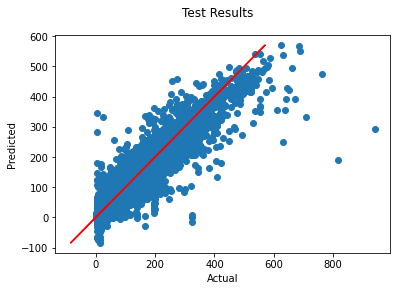

In [ ]:
# 1st hour prediction
pred = model.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test[:,0],pred[:,0]))
print("MSE:",metrics.mean_squared_error(y_test[:,0],pred[:,0]))

plt.scatter(y_test[:,0], pred[:,0])
plt.plot(pred[:,0], pred[:,0], color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


MAE: 41.460221512388884
MSE: 4415.043383637582


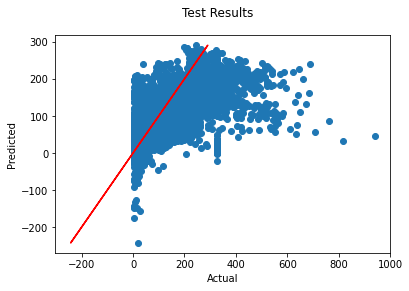

In [ ]:
# 12nd hour prediction
print("MAE:", metrics.mean_absolute_error(y_test[:,11],pred[:,11]))
print("MSE:",metrics.mean_squared_error(y_test[:,11],pred[:,11]))

plt.scatter(y_test[:,11], pred[:,11])
plt.plot(pred[:,11], pred[:,11], color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

MAE: 53.068400055791294
MSE: 6447.36510931283


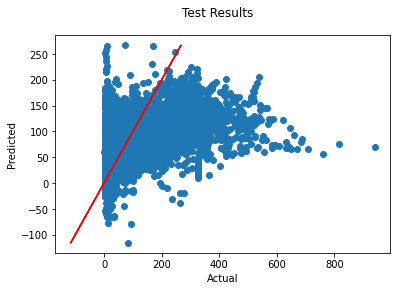

In [ ]:
# 24th hour prediction
print("MAE:", metrics.mean_absolute_error(y_test[:,23],pred[:,23]))
print("MSE:",metrics.mean_squared_error(y_test[:,23],pred[:,23]))

plt.scatter(y_test[:,23], pred[:,23])
plt.plot(pred[:,23], pred[:,23], color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

MAE:  40.50384444974637


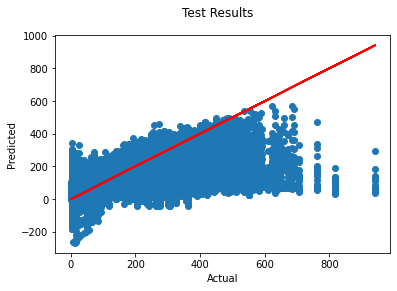

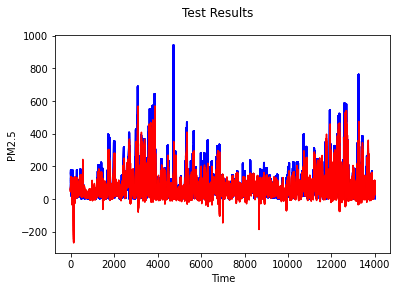

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(y, y, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.show()

# there are many negative prediction which is not relaible as concentration should over 0.

## Model2
adding complexity

In [ ]:
# now let's build a model

# define
n_steps = X_train.shape[1]
n_features = X_train.shape[2]


# define model
model_2 = Sequential()
model_2.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model_2.add(MaxPooling1D())
model_2.add(Conv1D(filters=32, kernel_size=3)) # notice how input shape goes in first layer
model_2.add(MaxPooling1D())
model_2.add(LSTM(30,
               return_sequences=True, # remember, if stacking layers, you need to return sequences!
               input_shape=(n_steps,n_features),
               activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(LSTM(20, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(n_steps_out))
model_2.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model_2.summary()

es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
history_2 = model_2.fit(X_train, y_train, 
          epochs=500, 
          batch_size=5, 
          validation_split=0.2, 
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 32)            1280      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 30)             7560      
_________________________________________________________________
dropout (Dropout)            (None, 4, 30)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)               

MAE: 46.36986345845859
MSE: 4851.1997319445045


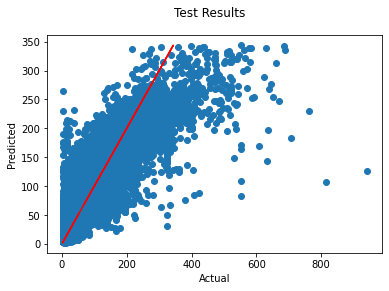

In [ ]:
# 1st hour prediction
pred_2 = model_2.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test[:,0],pred_2[:,0]))
print("MSE:",metrics.mean_squared_error(y_test[:,0],pred_2[:,0]))

plt.scatter(y_test[:,0], pred_2[:,0])
plt.plot(pred_2[:,0], pred_2[:,0], color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


MAE: 45.98926050604445
MSE: 4865.286141252174


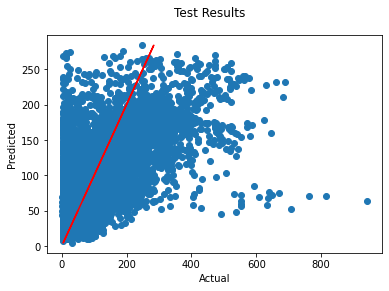

In [ ]:
# 2nd hour prediction
print("MAE:", metrics.mean_absolute_error(y_test[:,11],pred_2[:,11]))
print("MSE:",metrics.mean_squared_error(y_test[:,11],pred_2[:,11]))

plt.scatter(y_test[:,11], pred_2[:,11])
plt.plot(pred_2[:,11], pred_2[:,11], color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

MAE: 55.20312743187632
MSE: 6544.777650711758


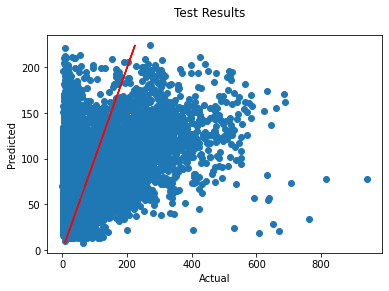

In [ ]:
# 24th hour prediction
print("MAE:", metrics.mean_absolute_error(y_test[:,23],pred_2[:,23]))
print("MSE:",metrics.mean_squared_error(y_test[:,23],pred_2[:,23]))

plt.scatter(y_test[:,23], pred_2[:,23])
plt.plot(pred_2[:,23], pred_2[:,23], color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

MAE:  45.4089411162152


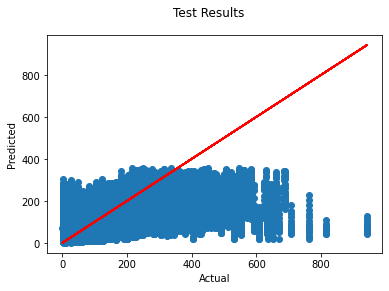

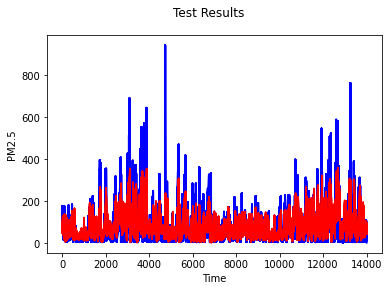

In [ ]:
# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred_2))

actual = y_test # the actual
plt.scatter(x=actual, y=pred_2)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(y, y, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred_2, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.show()

## Model 3

In [ ]:
# define shape
n_steps = X.shape[1]
n_features = X.shape[2]
n_outputs = y.shape[1]

print(n_steps, n_features, n_outputs)

# define model
model_3 = Sequential()
model_3.add(Conv1D(filters=20, kernel_size=3, input_shape=(n_steps,n_features))) 
model_3.add(MaxPooling1D())
model_3.add(Bidirectional(LSTM(10, activation='relu',return_sequences=True)))
#model.add(LSTM(10, activation='relu',recurrent_dropout=0.3, return_sequences=True))
model_3.add(GRU(10, activation='relu'))
model_3.add(Dense(n_outputs))
model_3.compile(optimizer='adam', loss='mse',metrics=['mae'])
model_3.summary()


# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, # you can play with this!
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# fit model (uses early stopping)
history_3 = model_3.fit(X_train, y_train, 
          epochs=500, 
          batch_size=5, 
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

24 13 24
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 22, 20)            800       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 11, 20)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 11, 20)            2480      
_________________________________________________________________
gru_2 (GRU)                  (None, 10)                960       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                264       
Total params: 4,504
Trainable params: 4,504
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
3362/3362 [==============================] - 56s 17ms/step - loss: 5323.0073 - mae: 52.7357 - val

MAE: 34.727504444762275
MSE: 2688.6554332181604


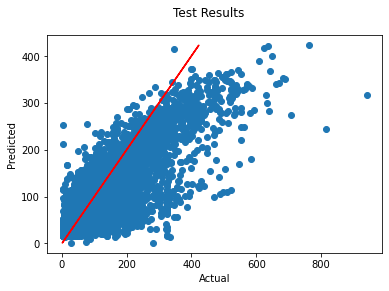

In [ ]:
# 1st hour prediction
pred_3 = model_3.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test[:,0],pred_2[:,0]))
print("MSE:",metrics.mean_squared_error(y_test[:,0],pred_2[:,0]))

plt.scatter(y_test[:,0], pred_3[:,0])
plt.plot(pred_3[:,0], pred_3[:,0], color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

MAE: 41.61629769213706
MSE: 4286.719478358513


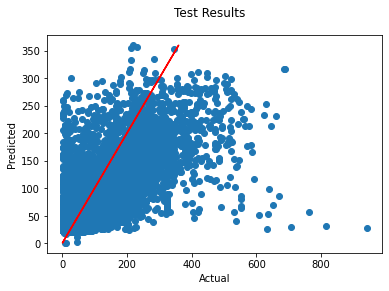

In [ ]:
# 12nd hour prediction
print("MAE:", metrics.mean_absolute_error(y_test[:,11],pred_3[:,11]))
print("MSE:",metrics.mean_squared_error(y_test[:,11],pred_3[:,11]))

plt.scatter(y_test[:,11], pred_3[:,11])
plt.plot(pred_3[:,11], pred_3[:,11], color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

MAE: 54.679624776306454
MSE: 6441.090484663598


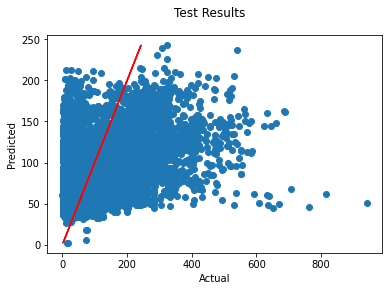

In [ ]:
# 24th hour prediction
print("MAE:", metrics.mean_absolute_error(y_test[:,23],pred_3[:,23]))
print("MSE:",metrics.mean_squared_error(y_test[:,23],pred_3[:,23]))

plt.scatter(y_test[:,23], pred_3[:,23])
plt.plot(pred_3[:,23], pred_3[:,23], color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

MAE:  41.94849082980595


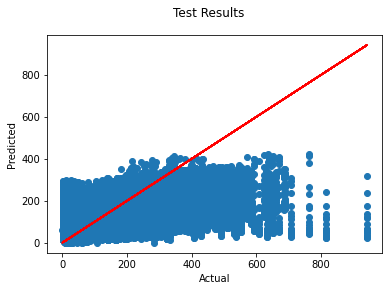

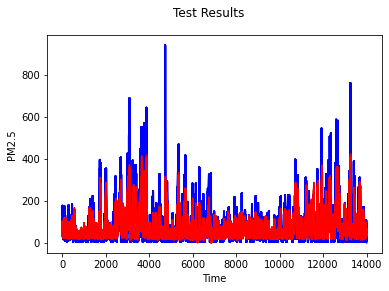

In [ ]:
# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred_3))

actual = y_test # the actual
plt.scatter(x=actual, y=pred_3)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(y, y, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred_3, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.show()

# Results and Discussion

## Learning curves

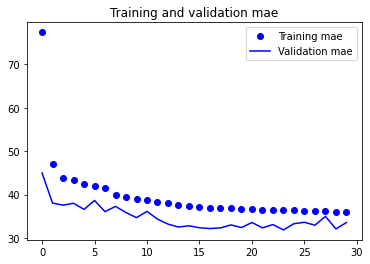

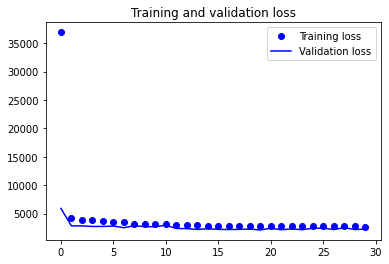

In [ ]:
#plot the learning curve for model1 
#compare accuracy and loss of train and validation data.
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

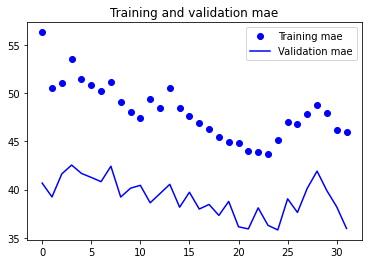

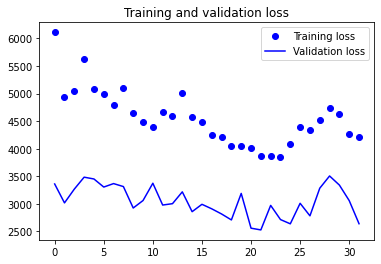

In [ ]:
#plot the learning curve for model2 
#compare accuracy and loss of train and validation data.
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

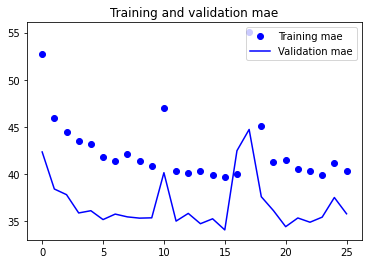

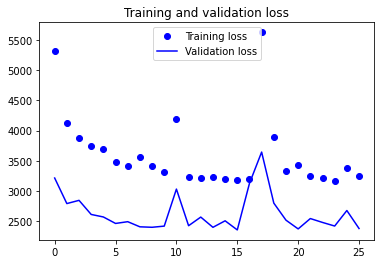

In [ ]:
#plot the learning curve for model3 
#compare accuracy and loss of train and validation data.
mae = history_3.history['mae']
val_mae = history_3.history['val_mae']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()